## HEART ATTACK PREDICTOR

In [ ]:
!pip install -q tensorflow-gpu --upgrade

     |████████████████████████████████| 454.3MB 41kB/s 


# IMPORTING MODULES

In [ ]:
# Importing required libraries 

import pandas as pd  # data processing, CSV file I/O (e.i. pd.read_csv)
import pandas_profiling as pp
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold,cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Feature Selection & Feature extraction
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA


#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier


# Stacking Models
from mlxtend.classifier import StackingCVClassifier

#Metrics & utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc #plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Misc
import joblib  #import pickle
from time import time
from scipy import stats
import os

# Tensorflow and Keras

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam,Adadelta,SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers


import sys
print()
print(sys.version)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)



3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Proceedit/'

print('Current working directory')
print(os.getcwd())
print('')
print('Changed to working directory')
os.chdir(path)
print(os.getcwd())

Current working directory
/content

Changed to working directory
/content/drive/My Drive/Colab Notebooks/Proceedit


In [ ]:
# project_path = r'/content/drive/My Drive/Colab Notebooks/Proceedit'
files = ['cleveland_expanded_data','hungarian_expanded_data','longbeachva_expanded_data',\
         'switzerland_expanded_data']

def load_data(file,file_path=path):
    csvfile = os.path.join(file_path,file +'.csv')
    return pd.read_csv(csvfile)

# DATASET

In [ ]:
cleve = load_data(files[0])
hung = load_data(files[1])
long = load_data(files[2])
switz = load_data(files[3])
total_df = pd.concat([cleve,hung,long,switz],ignore_index=True)
total_df.to_csv('total_df.csv')

print('TOTAL CONCATENATED DATASET SIZE : {}'.format(np.sum([cleve.shape[0],hung.shape[0],long.shape[0],switz.shape[0]])))
total_df.head()

TOTAL CONCATENATED DATASET SIZE : 899


,ID,CCF,AGE,SEX,PAINLOC,PAINEXER,RELREST,PNCADEN,CP,TRESTBPS,HTN,CHOL,SMOKE,CIGS,YEARS,FBS,DM,FAMHIST,RESTECG,EKGMO,EKGDAY,EKGYR,DIG,PROP,NITR,PRO,DIURETIC,PROTO,THALDUR,THALTIME,MET,THALACH,THALREST,TPEAKBPS,TPEAKBPD,DUMMY,TRESTBPD,EXANG,XHYPO,OLDPEAK,SLOPE,RLDV5,RLDV5E,CA,RESTCKM,EXERCKM,RESTEF,RESTWM,EXEREF,EXERWM,THAL,THALSEV,THALPUL,EARLPUL,CMO,CDAY,CYR,NUM,LMT,LADPROX,LADDIST,DIAG,CXMAIN,RAMUS,OM1,OM2,RCAPROX,RCADIST,LVX1,LVX2,LVX3,LVX4,LVF,CATHEF,JUNK,Unnamed: 75,#REF!
0,1,0,63,1,-9,-9,-9,-9,1,145,1,233,-9,50,20,1,-9,1,2,2,3,81,0,0,0,0,0,1,10.5,6.0,13.0,150,60,190,90,145,85,0,0,2.3,3,-9,172,0,-9,-9,-9.0,-9,-9.0,-9,6,-9,-9,-9,2,16,81,0,1,1,1,-9,1,-9,1,-9,1,1,1,1,1,1,1,-9.0,-9.0,name,NaN
1,2,0,67,1,-9,-9,-9,-9,4,160,1,286,-9,40,40,0,-9,1,2,3,5,81,0,1,0,0,0,1,9.5,6.0,13.0,108,64,160,90,160,90,1,0,1.5,2,-9,185,3,-9,-9,-9.0,-9,-9.0,-9,3,-9,-9,-9,2,5,81,2,1,2,2,-9,2,-9,1,-9,1,1,1,1,1,1,1,-9.0,-9.0,name,NaN
2,3,0,67,1,-9,-9,-9,-9,4,120,1,229,-9,20,35,0,-9,1,2,2,19,81,0,1,0,0,0,1,8.5,6.0,10.0,129,78,140,80,120,80,1,0,2.6,2,-9,150,2,-9,-9,-9.0,-9,-9.0,-9,7,-9,-9,-9,2,20,81,1,1,1,1,-9,1,-9,1,-9,2,2,1,1,1,7,3,-9.0,-9.0,name,NaN
3,4,0,37,1,-9,-9,-9,-9,3,130,0,250,-9,0,0,0,-9,1,0,2,13,81,0,1,0,0,0,1,13.0,13.0,17.0,187,84,195,68,130,78,0,0,3.5,3,-9,167,0,-9,-9,-9.0,-9,-9.0,-9,3,-9,-9,-9,2,4,81,0,1,1,1,-9,1,-9,1,-9,1,1,1,1,1,1,1,-9.0,-9.0,name,NaN
4,6,0,41,0,-9,-9,-9,-9,2,130,1,204,-9,0,0,0,-9,1,2,2,7,81,0,0,0,0,0,1,7.0,-9.0,9.0,172,71,160,74,130,86,0,0,1.4,1,-9,40,0,-9,-9,-9.0,-9,-9.0,-9,3,-9,-9,-9,2,18,81,0,1,1,1,-9,1,-9,1,-9,1,1,1,1,1,1,1,-9.0,-9.0,name,NaN


In [ ]:
# final concatenated dataframe for Cleveland + Hungarian + longbeach + Switzerland dataset
# creating two copies 

data = total_df.copy() 

total_dataset = total_df.copy()

total_dataset.to_csv('total_4_reduced_dataset.csv')

print('Total Number of patients involved in the original {0} study is {1} with {2} features '.format('cleveland_hungarian',len(data),len(data.columns)))

# data.drop(columns=['ID','CCF','Unnamed: 75'],inplace=True)

# target variable conversion to 0 & 1
data['NUM'] = np.where((data['NUM']>0),1,0)

# columns after applying ChiSquared selector for Feature selection

# data = data[['CHOL','OLDPEAK','CP','CXMAIN','THALTIME','LADDIST','RCAPROX','LADPROX','EXANG','THALACH','SLOPE','RLDV5E','OM1','NUM']]

print('------')
print('Total Number of patients involved in the reduced {0} study is {1} with {2} features '.format('cleveland_hungarian',len(data),len(data.columns)))
# data.head()


Total Number of patients involved in the original cleveland_hungarian study is 899 with 77 features 
------
Total Number of patients involved in the reduced cleveland_hungarian study is 899 with 77 features 


#### Attribute Description
- age: The person's age in years
- sex: The person's sex (1 = male, 0 = female)
- cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
- chol: The person's cholesterol measurement in mg/dl
- fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- thalach: The person's maximum heart rate achieved
- exang: Exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
- slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- ca: The number of major vessels (0-3)
- thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- target: Heart disease (0 = no, 1 = yes)

### MISSING VALUES & DUPLICATES

In [ ]:
def check_missing_duplicated(data):
    # checking NA and Missing values
    print('Number of NA\'s in the dataset')
    print(data.isna().sum())
    print('')
    print('Total missing values in the dataset')
    print(data.isnull().sum())

    # check for duplicates

    print('')
    print('Number of duplicates')
    print(data.duplicated().sum())
    duplicate_data = data[data.duplicated(keep=False)].sort_values(by=['CHOL'], ascending= False) 
    duplicate_data.head()
    
    # dropping duplicates
    data.drop_duplicates(inplace=True)
    print('Duplicates count after dropping : {}'.format(data.duplicated().sum()))
    print('Number of observations after dropping duplicates : {}'.format(len(data)))
    
check_missing_duplicated(data)

Number of NA's in the dataset
ID               0
CCF              0
AGE              0
SEX              0
PAINLOC          0
              ... 
LVF              0
CATHEF           0
JUNK             0
Unnamed: 75    123
#REF!          776
Length: 77, dtype: int64

Total missing values in the dataset
ID               0
CCF              0
AGE              0
SEX              0
PAINLOC          0
              ... 
LVF              0
CATHEF           0
JUNK             0
Unnamed: 75    123
#REF!          776
Length: 77, dtype: int64

Number of duplicates
0
Duplicates count after dropping : 0
Number of observations after dropping duplicates : 899


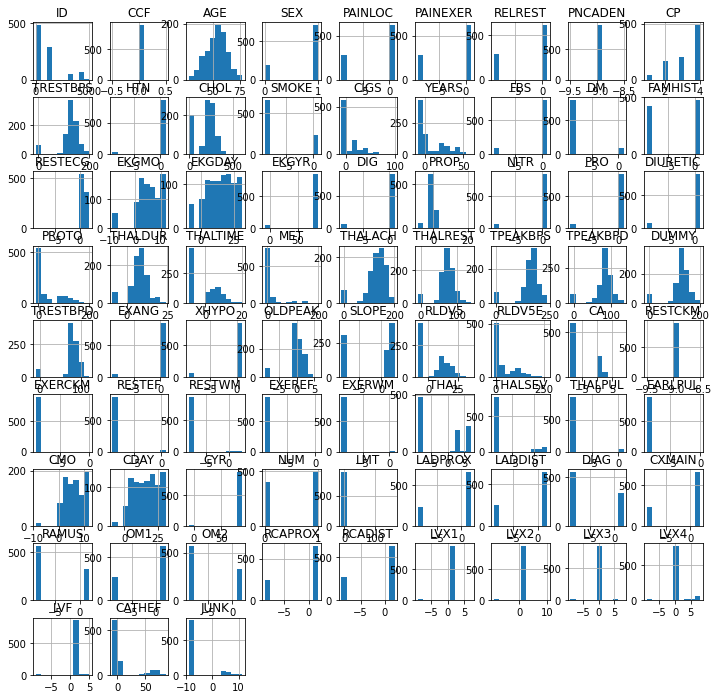

In [ ]:
# plot histograms for each variable
data.hist(figsize = (12, 12))
plt.show()

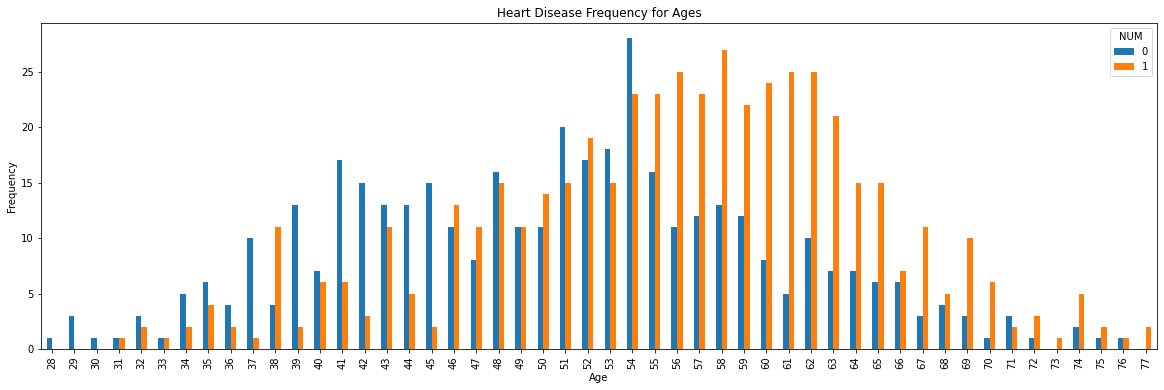

In [ ]:
pd.crosstab(data['AGE'],data['NUM']).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# FUNCTION TO FILL WITH RANDOM VALUES FOR MISSING VALUES (-9's)
# np.random.randint(2,size = ch_copy_pre[col].value_counts().values[0]))

def fill_missing(value):
    
    for i in range(len(ch_copy_pre)):
        
        if value == -9: 
            value = np.random.choice(ch_copy_pre[ch_copy_pre[col] != -9][col])
            
        else:
            value = value
    
    return value

### PREPROCESSING DATAFRAME

In [ ]:
# PREPROCESSING DATAFRAME
# Experiment with Raw Data + SIX ML Classifiers 

#Feature Selection for Cleveland + Hungarian + Longbeach + switzerland Dataset

ch_copy_pre = total_dataset.copy()


print('Total Number of observations in our analysis [BEFORE] : {}'.format(len(ch_copy_pre)))
print('Total Number of columns Before Feature Selection      : {}'.format(len(ch_copy_pre.columns)))


# Pre-processing condition for variables

#  Dropping columns as mentioned in table-4 along with excluded features mentioned in the paper

column_names = ['ID','CCF','PAINLOC','PNCADEN','SMOKE','DM','FAMHIST','EKGMO','EKGDAY','EKGYR','DUMMY', \
                        'RESTCKM', 'EXERCKM','RESTEF','RESTWM', 'EXEREF', 'EXERWM','THALSEV', 'THALPUL', 'EARLPUL',\
                         'CMO', 'CDAY', 'CYR','LVX1', 'LVX2','LVX3', 'LVX4','LVF','RLDV5','DIAG','RAMUS','OM2',\
                          'CATHEF', 'JUNK','Unnamed: 75','#REF!']

ch_copy_pre = ch_copy_pre.drop(columns= column_names)

print('')
print('Number of columns dropped as described in the table-4 : {}'.format(len(column_names)))


# 1. target variable conversion to 0 & 1
ch_copy_pre['NUM'] = np.where((ch_copy_pre['NUM']>0),1,0)

# 2a. CONTINUOUS VARIABLES : Applying Imputation for data consistency 

ch_copy_pre['THALDUR'] = ch_copy_pre['THALDUR'].replace(-9,round((ch_copy_pre['THALDUR']!=-9).mean(),1))
ch_copy_pre['THALTIME'] = ch_copy_pre['THALTIME'].replace(-9,round((ch_copy_pre['THALTIME']!=-9).mean(),1))
ch_copy_pre['OLDPEAK'] = ch_copy_pre['OLDPEAK'].replace(-9,round((ch_copy_pre['OLDPEAK']!=-9).mean(),1))
ch_copy_pre['CHOL'] = ch_copy_pre['CHOL'].replace(0,int(ch_copy_pre['CHOL'].mean()))
ch_copy_pre['TRESTBPS'] = ch_copy_pre['TRESTBPS'].replace(0,int(ch_copy_pre['CHOL'].mean()))
ch_copy_pre['YEARS'] = ch_copy_pre['YEARS'].replace(0,int(ch_copy_pre['YEARS'].mean()))
ch_copy_pre['CIGS'] = ch_copy_pre['CIGS'].replace(0,int(ch_copy_pre['CIGS'].mean()))


ch_copy_pre['PROTO'] = ch_copy_pre['PROTO'].apply(lambda x: 150 if x > 125 else x)

ch_copy_pre['PROTO'] = ch_copy_pre['PROTO'].map({-9:1,1:1,2:2,3:3,4:4,5:5,6:6,150:7,125:8,100:9,75:10,50:11,12:12,25:12})

ch_copy_pre['OLDPEAK'] = ch_copy_pre['OLDPEAK'].apply(lambda x: np.abs(x) if x < 0 else x)

cont_col = ['CHOL','CIGS', 'YEARS','MET','THALACH','THALREST','TPEAKBPS','TRESTBPS','TPEAKBPD','TRESTBPD','RLDV5E']

for col in cont_col:
    ch_copy_pre[col] = ch_copy_pre[col].replace(-9,int(ch_copy_pre[col].mean()))
   
# 2b. CATEGORICAL VARIABLES : Applying Imputation for data consistency
# choosing unique label based on categories present
# [DANGER AREA WITH -9]

categ_col = ['SEX', 'PAINEXER', 'RELREST','HTN','FBS','DIG', 'PROP', 'NITR', 'PRO','DIURETIC','EXANG', 'XHYPO',\
            'LMT','LADPROX','LADDIST', 'CXMAIN', 'OM1', 'RCAPROX', 'RCADIST','RESTECG','SLOPE','CA','THAL']

for col in categ_col:
    ch_copy_pre[col] = ch_copy_pre[col].apply(fill_missing)
    

ch_copy_pre['SLOPE'] = ch_copy_pre['SLOPE'].apply(lambda x: 1 if x == 0 else x)
ch_copy_pre['CA'] = ch_copy_pre['CA'].apply(lambda x: 3 if x > 3 else x)
ch_copy_pre['THAL'] = ch_copy_pre['THAL'].apply(lambda x : 3 if x <=3 else (6 if (x > 3 and x <= 6) else x))

ch_copy_pre['LADPROX'] = np.where((ch_copy_pre['LADPROX']>1),1,0)
ch_copy_pre['LADDIST'] = np.where((ch_copy_pre['LADDIST']>1),1,0)
ch_copy_pre['CXMAIN'] = np.where((ch_copy_pre['CXMAIN']>1),1,0)
ch_copy_pre['OM1'] = np.where((ch_copy_pre['OM1']>1),1,0)
ch_copy_pre['RCAPROX'] = np.where((ch_copy_pre['RCAPROX']>1),1,0)

# 5. drop if Thaltime > thaldur
# 6. drop if thalach < thalrest
print('')
print('Total Number of rows dropped (where THALTIME > THALDUR) : {}'.format(len(ch_copy_pre[ch_copy_pre['THALTIME'] > ch_copy_pre['THALDUR']])))
ch_copy_pre = ch_copy_pre.drop(ch_copy_pre[ch_copy_pre['THALTIME'] > ch_copy_pre['THALDUR']].index)

print('Total Number of rows dropped (where THALACH < THALREST) : {}'.format(len(ch_copy_pre[ch_copy_pre['THALACH'] < ch_copy_pre['THALREST']])))
ch_copy_pre = ch_copy_pre.drop(ch_copy_pre[ch_copy_pre['THALACH'] < ch_copy_pre['THALREST']].index)

print('')

# 7. if oldpeak = 0 then convert thaltime = 0
ch_copy_pre.loc[(ch_copy_pre['OLDPEAK']==0),'THALTIME'] = 0


# resetting index

ch_copy_pre.reset_index(inplace=True)
ch_copy_pre.drop(columns='index',inplace=True)

print('')
print('Total Number of observations in our analysis [AFTER]  : {}'.format(len(ch_copy_pre)))
print('Total Number of columns After Feature Selection       : {}'.format(len(ch_copy_pre.columns)))

# saving the dataset as csv after feature selection
ch_copy_pre.to_csv('har_cleve_hung_longbeach_switz_reduced_preprocessed.csv')

ch_copy_pre.head()


Total Number of observations in our analysis [BEFORE] : 899
Total Number of columns Before Feature Selection      : 77

Number of columns dropped as described in the table-4 : 36

Total Number of rows dropped (where THALTIME > THALDUR) : 27
Total Number of rows dropped (where THALACH < THALREST) : 1


Total Number of observations in our analysis [AFTER]  : 871
Total Number of columns After Feature Selection       : 41


,AGE,SEX,PAINEXER,RELREST,CP,TRESTBPS,HTN,CHOL,CIGS,YEARS,FBS,RESTECG,DIG,PROP,NITR,PRO,DIURETIC,PROTO,THALDUR,THALTIME,MET,THALACH,THALREST,TPEAKBPS,TPEAKBPD,TRESTBPD,EXANG,XHYPO,OLDPEAK,SLOPE,RLDV5E,CA,THAL,NUM,LMT,LADPROX,LADDIST,CXMAIN,OM1,RCAPROX,RCADIST
0,63,1,1,0,1,145,1,233,50,20,1,2,0,0,0,0,0,1,10.5,6.0,13.0,150,60,190,90,85,0,0,2.3,3,172,0,6,0,1,0,0,0,0,0,1
1,67,1,0,1,4,160,1,286,40,40,0,2,0,1,0,0,0,1,9.5,6.0,13.0,108,64,160,90,90,1,0,1.5,2,185,3,3,1,1,1,1,1,0,0,1
2,67,1,1,1,4,120,1,229,20,35,0,2,0,1,0,0,0,1,8.5,6.0,10.0,129,78,140,80,80,1,0,2.6,2,150,2,7,1,1,0,0,0,0,1,2
3,37,1,1,1,3,130,0,250,5,5,0,0,0,1,0,0,0,1,13.0,13.0,17.0,187,84,195,68,78,0,0,3.5,3,167,0,3,0,1,0,0,0,0,0,1
4,41,0,1,1,2,130,1,204,5,5,0,2,0,0,0,0,0,1,7.0,0.5,9.0,172,71,160,74,86,0,0,1.4,1,40,0,3,0,1,0,0,0,0,0,1


# CHI SQUARED ANALYSIS¶

In [ ]:
from sklearn.feature_selection import SelectKBest,chi2
from scipy import stats

#Preparing the data for ChiSquared statistical analysis 

chi_X = ch_copy_pre.drop('NUM',axis=1)
chi_y = ch_copy_pre['NUM']

# Convert to categorical data by converting data to integers
# X = X.astype(int)

# Select 13 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=22)
chi2_selector.fit_transform(chi_X,chi_y)


# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(ch_copy_pre.columns, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['Feature', 'ChiScore', 'P-value'])
chi2_scores

# you can see that the kbest returned from SelectKBest 
#+ were the features with the _highest_ score
kbest = np.asarray(chi_X.columns)[chi2_selector.get_support()]
kbest

array(['AGE', 'PAINEXER', 'CP', 'TRESTBPS', 'CIGS', 'YEARS', 'THALDUR',
       'THALTIME', 'MET', 'THALACH', 'THALREST', 'TPEAKBPS', 'EXANG',
       'OLDPEAK', 'RLDV5E', 'CA', 'THAL', 'LADPROX', 'LADDIST', 'CXMAIN',
       'OM1', 'RCAPROX'], dtype=object)

P-VALUES
     Feature     ChiScore        P-value
0        AGE   118.126957   1.626376e-27
1        SEX    19.080684   1.253067e-05
2   PAINEXER    40.578165   1.889059e-10
3    RELREST    28.882981   7.688551e-08
4         CP    50.998725   9.242597e-13
5   TRESTBPS    35.827969   2.155314e-09
6        HTN     1.908277   1.671547e-01
7       CHOL     0.225823   6.346383e-01
8       CIGS   110.743419   6.734671e-26
9      YEARS   123.216924   1.250069e-28
10       FBS    13.391538   2.527621e-04
11   RESTECG     3.505677   6.115885e-02
12       DIG     0.420592   5.166416e-01
13      PROP    23.204253   1.456748e-06
14      NITR    27.537866   1.540488e-07
15       PRO    19.509916   1.000788e-05
16  DIURETIC     4.359912   3.679421e-02
17     PROTO     2.600797   1.068100e-01
18   THALDUR   141.671908   1.147152e-32
19  THALTIME   155.553687   1.059736e-35
20       MET  2629.355261   0.000000e+00
21   THALACH   607.066071  4.862810e-134
22  THALREST   105.559056   9.211143e-25
23  TPE

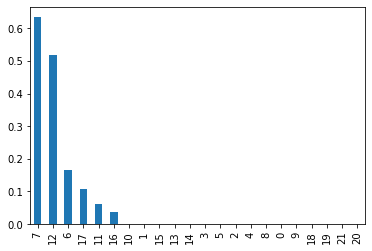

In [ ]:
print('P-VALUES')
print(chi2_scores)
print('')
print('PLOTTING P-VALUES')
chi2_scores['P-value'][0:22].sort_values(ascending = False).plot.bar()

## FEATURE SELECTION AFTER CHI-SQUARED ANALYSIS

In [ ]:
## working with features that are identified by ChiSquare + Few Additional features

# 22 features 
subset_ch_copy_pre = ch_copy_pre[['CHOL','CP','CIGS','YEARS','PAINEXER','RELREST','RESTECG','PROTO','OLDPEAK','CXMAIN','CA',\
                                  'THALDUR','THAL','THALTIME','LADDIST','RCAPROX','LADPROX',
                                  'EXANG','THALACH','SLOPE', 'RLDV5E','OM1','NUM']]

subset_ch_copy_pre.to_csv('subset_ch_copy.csv',index=False)
subset_ch_copy_pre.corr()

,CHOL,CP,CIGS,YEARS,PAINEXER,RELREST,RESTECG,PROTO,OLDPEAK,CXMAIN,CA,THALDUR,THAL,THALTIME,LADDIST,RCAPROX,LADPROX,EXANG,THALACH,SLOPE,RLDV5E,OM1,NUM
CHOL,1.000000,0.022291,-0.044566,0.011270,0.067458,0.000670,0.097594,-0.078394,0.039517,0.063144,0.016814,0.031244,-0.046667,0.090416,0.007699,0.087035,0.020652,0.044523,0.069304,-0.001307,0.085047,0.032418,-0.004402
CP,0.022291,1.000000,0.094421,0.090681,0.580855,0.572466,0.038058,-0.006451,0.239752,0.134053,0.061932,-0.224659,0.129650,0.109806,0.143511,0.151667,0.170939,0.405970,-0.336900,0.152997,-0.034267,0.100120,0.470125
CIGS,-0.044566,0.094421,1.000000,0.609395,0.009846,0.059092,0.130624,-0.359429,0.057876,-0.020043,0.024752,-0.196680,0.024304,-0.056318,-0.076778,-0.014060,-0.078433,0.055689,0.020806,-0.018538,0.216741,0.002939,0.093193
YEARS,0.011270,0.090681,0.609395,1.000000,0.045406,0.120607,0.141435,-0.423939,0.097226,-0.018745,0.057219,-0.276929,0.011025,-0.039617,-0.073770,-0.026800,-0.061323,0.073147,-0.034926,-0.054669,0.186690,0.035096,0.108796
PAINEXER,0.067458,0.580855,0.009846,0.045406,1.000000,0.458693,0.042401,-0.034392,0.208907,0.063643,-0.018549,-0.159999,0.021025,0.100752,0.067310,0.106867,0.080818,0.297979,-0.203628,0.080944,0.054804,0.000799,0.341473
RELREST,0.000670,0.572466,0.059092,0.120607,0.458693,1.000000,-0.000346,-0.066447,0.181148,0.095678,0.058801,-0.164842,0.005739,0.035177,0.063591,0.080182,0.077277,0.254904,-0.203994,0.089842,0.036175,0.042392,0.313435
RESTECG,0.097594,0.038058,0.130624,0.141435,0.042401,-0.000346,1.000000,-0.361761,0.113632,-0.055045,0.044882,-0.176223,-0.033157,-0.025084,-0.048833,-0.011695,-0.058771,0.027293,0.045722,0.000510,0.289827,0.031593,0.061318
PROTO,-0.078394,-0.006451,-0.359429,-0.423939,-0.034392,-0.066447,-0.361761,1.000000,-0.159631,0.191546,0.015980,0.138785,0.151444,-0.066988,0.118770,0.238258,0.256215,0.071864,-0.251893,0.128799,-0.576153,0.027110,0.029014
OLDPEAK,0.039517,0.239752,0.057876,0.097226,0.208907,0.181148,0.113632,-0.159631,1.000000,0.125817,0.122270,-0.271590,0.096142,0.464494,0.186487,0.164688,0.109148,0.395557,-0.171177,0.329669,0.167670,0.130060,0.399659
CXMAIN,0.063144,0.134053,-0.020043,-0.018745,0.063643,0.095678,-0.055045,0.191546,0.125817,1.000000,0.050269,-0.038330,0.140792,0.015939,0.140201,0.251494,0.121851,0.182085,-0.182074,0.150816,-0.180674,0.148531,0.330592


## CORRELATION

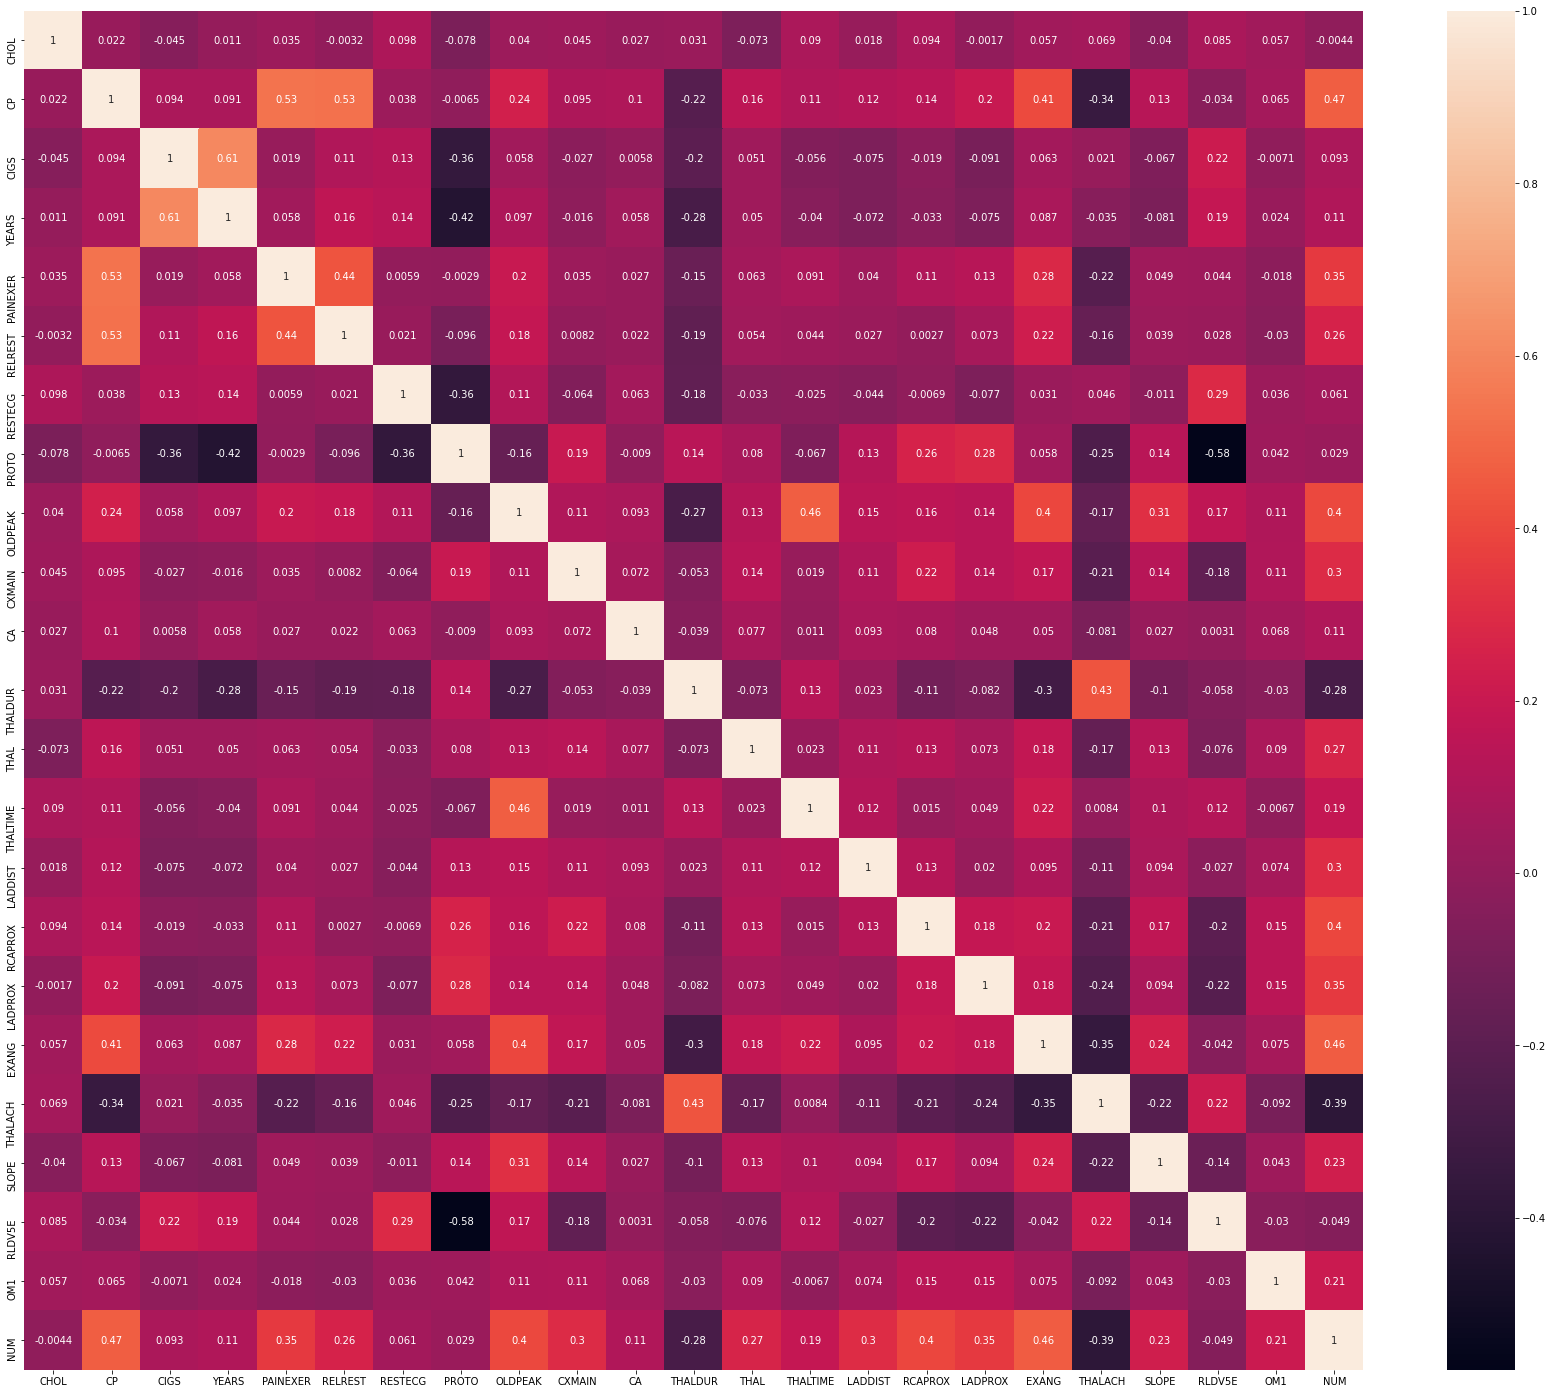

In [ ]:
# correlation among identified features 

plt.figure(figsize=(30,25))
sns.heatmap(subset_ch_copy_pre.corr(),annot=True)
plt.savefig('correlation_11.png')
plt.show()

### TOP 5 CORRELATION PAIRS

In [ ]:
# map features to their absolute correlation values
corr_matrix = data.corr().unstack()

# set equality (self correlation) as zero
corr_matrix[corr_matrix == 1] = 0

# of each feature, find the max correlation
# and sort the resulting array in ascending order
corr = corr_matrix.sort_values(ascending=False)

column_name = {0:'Pearson Coefficient'}
corr = pd.DataFrame(corr,columns=column_name)
corr.rename(columns=column_name,inplace=True)

corr.head(10)

# display the highly correlated features
# display(corr[corr > 0.8])

Pearson Coefficient
PAINEXER PAINLOC              0.995861
PAINLOC  PAINEXER             0.995861
PAINEXER RELREST              0.988676
RELREST  PAINEXER             0.988676
         PAINLOC              0.986169
PAINLOC  RELREST              0.986169
NITR     PRO                  0.964188
PRO      NITR                 0.964188
RAMUS    OM2                  0.963870
OM2      RAMUS                0.963870

# PRINCIPAL COMPONENT ANALYSIS

In [ ]:
# Feature Extraction using PCA 
# k = 11 as described in the paper


#Preparing the data for PCA analysis 

pca_X = subset_ch_copy_pre.drop('NUM',axis=1)
pca_y = subset_ch_copy_pre['NUM']


# Scaling the Data and Creating the array
scaler = StandardScaler()

pca_X = scaler.fit_transform(pca_X.values)
pca_y = pca_y.values

# covariance matrix
pca_cov_matrix = PCA(n_components=22)

# calculate eigen values
pca_cov_matrix.fit(pca_X)
X_pc = pca_cov_matrix.transform(pca_X)

variance_ratio = pca_cov_matrix.explained_variance_ratio_
var=np.cumsum(np.round(variance_ratio,3)*100)


print('Features with Eigen value One Criteria')
print(pca_cov_matrix.explained_variance_)

print('-------')
print('Cumulative sum of variance explained with [n] features')
print(var)


# number of components
pca_components = pca_cov_matrix.n_components_

# get the index of the most important feature on EACH component

most_important = [np.abs(pca_cov_matrix.components_[i]).argmax() for i in range(pca_components)]

# print(most_important)

initial_feature_names = subset_ch_copy_pre.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca_components)]

print('-------')
print('Variance explained with feature names')
print(most_important_names)

# Dictionary of PCA Components with Features
dic = {'PC{}'.format(i): most_important_names[i] for i in range(pca_components)}

# build the dataframe with component and feature name (best feature of each component)
df = pd.DataFrame(dic.items(),columns=['COMPONENT','FEATURE'])

# DATASET after PCA

# Reduced dataset after applying PCA 
pca_df = pd.DataFrame(X_pc,columns=dic.keys())

pca_df['LABEL'] = subset_ch_copy_pre['NUM']

pca_df.to_csv('pca_df.csv')
print('')
print('Number rows dropping : {}'.format(len(pca_df[pca_df['LABEL'].isna()].index)))

pca_df = pca_df.drop(pca_df[pca_df['LABEL'].isna()].index)

Features with Eigen value One Criteria
[3.37978012 2.77318825 1.61813198 1.49331166 1.17928008 1.11355067
 1.03073465 0.95317403 0.9050133  0.8616697  0.80556037 0.7877201
 0.76678898 0.71303482 0.62531293 0.58369837 0.54839423 0.475968
 0.39638835 0.39126949 0.32942337 0.29389391]
-------
Cumulative sum of variance explained with [n] features
[ 15.3  27.9  35.2  42.   47.4  52.5  57.2  61.5  65.6  69.5  73.2  76.8
  80.3  83.5  86.3  89.   91.5  93.7  95.5  97.3  98.8 100.1]
-------
Variance explained with feature names
['CP', 'PROTO', 'THALTIME', 'PAINEXER', 'CHOL', 'THALDUR', 'CA', 'OM1', 'CA', 'LADDIST', 'SLOPE', 'CXMAIN', 'CHOL', 'LADPROX', 'RESTECG', 'RELREST', 'EXANG', 'PAINEXER', 'CP', 'PROTO', 'OLDPEAK', 'PROTO']

Number rows dropping : 0


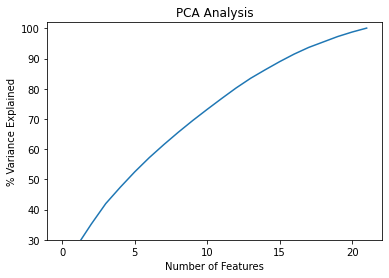

In [ ]:
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,102)
plt.style.context('seaborn-whitegrid')


plt.plot(var)

### DATASET AFTER PCA

In [ ]:
pca_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,LABEL
0,-0.553957,3.309257,1.076442,1.164557,-1.195938,1.164988,0.270752,-1.078428,-0.754988,-0.270216,0.285260,1.075757,0.278410,-1.976824,0.174844,0.786278,-0.514574,-0.679979,2.648414,-0.218403,0.146076,-0.674204,0
1,2.672568,3.076884,0.663009,1.135477,1.438540,-0.145024,-0.584657,1.297169,1.738238,0.194504,1.474786,-0.195640,-1.959125,-1.090265,-1.150110,-0.923020,-1.708429,0.246194,0.986080,-0.475562,0.375486,0.342977,1
2,1.010112,2.489207,0.935305,2.638303,-0.295561,0.048049,-0.420278,0.203172,-0.160439,-0.671302,-2.156266,1.073418,-0.631758,0.576967,-0.427481,-0.420881,-1.034642,0.527211,-0.691665,0.193267,0.511428,1.136007,1
3,-0.429622,1.468530,4.709719,-0.825847,-1.341202,1.543657,0.512025,-1.281017,0.727723,0.144149,0.693638,1.313049,0.570815,-0.774110,1.213798,0.405850,-0.112633,-0.485438,0.166241,0.316328,-0.270655,0.362129,0
4,-3.086520,0.705457,0.624665,0.480897,-1.313329,-1.017086,-0.223618,-0.236457,-0.842592,0.625319,-0.126843,-0.033492,-0.943376,0.565294,-0.667891,0.161065,1.499238,-0.194178,-0.584927,0.356296,0.623424,-0.250550,0


# SPLITTING THE DATA INTO TRAINING & TEST DATASETS

### RAW INPUT

In [ ]:
# input data 
X = subset_ch_copy_pre.drop('NUM',axis=1)
y = subset_ch_copy_pre['NUM']

# Making a copies of Original data for Testing
Xx = X.values
yy = y.values

# Scaling the Data and Creating the array
normalize = MinMaxScaler()
scaler = StandardScaler()

# X = normalize.fit_transform(X.values)
X = scaler.fit_transform(X.values)

y = y.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,stratify=y,test_size=0.2,random_state=103)

print('TRAINING SIZE : {}'.format(Xtrain.shape))

print('TESTING SIZE : {}'.format(Xtest.shape))

TRAINING SIZE : (696, 22)
TESTING SIZE : (175, 22)


### PCA INPUT DATA

In [ ]:
# PCA Input data 
pc_X = pca_df.drop('LABEL',axis=1)
pc_y = pca_df['LABEL']


# Scaling the Data and Creating the array
# scaler = StandardScaler()

pc_X = scaler.fit_transform(pc_X.values)
pc_y = pc_y.values


Xtrain, Xtest, ytrain, ytest = train_test_split(pc_X,pc_y,stratify=pc_y,test_size=0.2,random_state=103)

print('TRAINING SIZE : {}'.format(Xtrain.shape))

print('TESTING SIZE : {}'.format(Xtest.shape))

TRAINING SIZE : (696, 22)
TESTING SIZE : (175, 22)


# MACHINE LEARNING MODELS ENSEMBLING / STACKING 

### Stacking models with hyperparameter tuning

In [ ]:
# stacking models with hyperparameter tuning

def stacked_model():
    
    # BASE MODELS
    
    dt  = DecisionTreeClassifier(criterion='entropy')
    
    rfc =  RandomForestClassifier(n_estimators=500,max_features=0.25,criterion='entropy')
    
    gbc = GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.1,n_estimators=500,max_depth=3,max_features='log2')
    
    nb = GaussianNB()
    
    svc = SVC(kernel='poly',C=0.01,gamma=0.1,degree=3,coef0=10.0)
    
    mlp = MLPClassifier(hidden_layer_sizes=(32,64,32), activation='relu',learning_rate='constant',solver='adam')
    
    xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
    
    
    # META MODEL
    # for classification problem by default the metamodel is LR, for Regression it is Linear Regression
    
    metamodel = LogisticRegression(C=1.5,penalty='l2',fit_intercept=True)
    
    
    # STACKING OF CLASSIFIERS

    model = StackingCVClassifier(classifiers=[rfc,gbc,mlp,svc,xgb],meta_classifier=metamodel)
    
    return model
    

### Create a dictionary for models

In [ ]:
# create a dictionary for models

def loading_models():
    models = dict()
    models['Logistic Regression'] = LogisticRegression(C=1.5,penalty='l2',fit_intercept=True)
    models['k-Nearest'] = KNeighborsClassifier()
    models['Decision Tree'] = DecisionTreeClassifier()
    models['Random Forest'] = RandomForestClassifier(n_estimators=500,max_features=0.25,criterion='entropy')
    models['Support Vector'] = SVC(C=0.01,gamma=0.1,kernel="poly",degree=3,coef0=10.0)
    models['Naive Bayes']  = GaussianNB()
    models['Gradient Boosting'] =  GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.1,n_estimators=500,max_depth=3,max_features='log2')
    models['MultiLayer Perceptron'] = MLPClassifier(hidden_layer_sizes=(10,50,100,50,10), activation='relu',
                         learning_rate='constant',solver='adam')
    models['Xtreme Gradient'] = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)

    models['Stacked Model'] = stacked_model()
    return models

### Evaluate the models using cross-validation

In [ ]:
# evaluate the models using cross-validation
from sklearn.model_selection import cross_validate

def evaluating_model(model,X,y):
    scoring = ['accuracy','precision','recall','f1']
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    scores = cross_validate(model,X,y,cv=cv,scoring=scoring,n_jobs=-1,error_score='raise')
    return scores

### Machine Learning Models results

In [ ]:
# Results: Experiment 4 trial 1 with raw data + PCA 

models = loading_models()

# evaluate the  models and store the results
results,names = list(),list()

for name,model in tqdm(models.items()):

    scores = evaluating_model(model,X,y)
    results.append(scores)
    names.append(name)

    
# Final Results
      
results_df = pd.DataFrame(columns=['ACCURACY(%)','PRECISION(%)','RECALL(%)','F1_SCORE(%)'],)

for dic,name in zip(results,names):
    accuracy = np.mean((dic['test_accuracy']*100))
    precision = np.mean(dic['test_precision']*100)
    recall = np.mean(dic['test_recall']*100)
    f1_score = np.mean(dic['test_f1']*100)
    
    results_df.loc[name] = [accuracy,precision,recall,f1_score]

# results_df.to_csv('results_df_ex.csv')
results_df.round(1).sort_values('ACCURACY(%)',ascending=True)

,ACCURACY(%),PRECISION(%),RECALL(%),F1_SCORE(%)
MultiLayer Perceptron,85.3,87.4,85.5,86.3
Xtreme Gradient,86.0,87.9,86.3,87.0
Naive Bayes,86.2,87.6,87.1,87.3
k-Nearest,86.4,93.4,80.9,86.5
Logistic Regression,86.5,88.1,87.1,87.5
Decision Tree,87.1,88.4,87.9,88.0
Random Forest,90.2,92.1,90.0,90.9
Support Vector,91.6,93.3,91.3,92.2
Stacked Model,92.1,92.8,92.8,92.7
Gradient Boosting,92.3,93.5,92.3,92.8


# FINALIZING THE MODEL FOR DEPLOYMENT

In [ ]:
# Model Performance on the Test data
# Picked only the final estimator after stacking is performed
stackedModel = stacked_model()
stackedModel.fit(Xtrain,ytrain)
print('Final stacked Model Accuracy : {:0.2f} %'.format(stackedModel.score(Xtest,ytest)*100))

Final stacked Model Accuracy : 91.43 %


## RESULTS
### CONFUSION MATRIX & METRICS

In [ ]:
y_stacked_pred = stackedModel.predict(Xtest)

confusionMatrix = confusion_matrix(ytest,y_stacked_pred)
print('Confusion Matrix')
print(confusionMatrix)
print()
print('TEST DATASET SIZE : {}'.format(len(Xtest)))
print('')
print('TRUE POSITIVIES  : {}'.format(confusionMatrix[1][1]))
print('FALSE POSITIVIES : {}'.format(confusionMatrix[0][1]))
print('TRUE NEGATIVES   : {}'.format(confusionMatrix[0][0]))
print('FALSE NEGATIVES  : {}'.format(confusionMatrix[1][0]))

print()
print('Classification Report')
print()
classNames = ['No Disease', 'Disease']
print(classification_report(ytest,y_stacked_pred, target_names=classNames))


Confusion Matrix
[[68 12]
 [ 3 92]]

TEST DATASET SIZE : 175

TRUE POSITIVIES  : 92
FALSE POSITIVIES : 12
TRUE NEGATIVES   : 68
FALSE NEGATIVES  : 3

Classification Report

              precision    recall  f1-score   support

  No Disease       0.96      0.85      0.90        80
     Disease       0.88      0.97      0.92        95

    accuracy                           0.91       175
   macro avg       0.92      0.91      0.91       175
weighted avg       0.92      0.91      0.91       175



In [ ]:
# saving the model to use it in applications
import joblib
HeartRiskModel = 'proceedit_ml_heart_risk_pred.sav'
joblib.dump(stackedModel,HeartRiskModel)

stacked_output = joblib.load(HeartRiskModel)

result_jbl = stacked_output.score(Xtest,ytest)
result_jbl

0.9485714285714286

# Neural Network

In [ ]:
# Negative log likelihood
def negative_log_likelihood(y_true, y_pred):
  """
  Minimizing the negative log-likelihood of our data with respect to θ given a Gaussian prior on θ 
  is equivalent to minimizing the binary cross-entropy (i.e. binary log loss) between the observed y 
  and our prediction of the probability thereof, plus the squared sum of (the elements of) θ itself.
  """
  return -K.mean(y_true * K.log(y_pred))

In [ ]:
del model

In [ ]:
Xtest.shape

(175, 22)

In [ ]:
def create_nn_model():
  model = Sequential()
  model.add(Dense(128,input_dim=X.shape[1],kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.001),
                  activation='relu'))   #activity_regularizer=regularizers.l1(0.001),
  # model.add(BatchNormalization())
  model.add(Dropout(0.20))
  model.add(Dense(64,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.001),activation='relu'))
  # model.add(Dropout(0.20))
  # model.add(Dense(32,kernel_initializer='normal',kernel_regularizer=regularizers.l2(0.001),activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  # Compile
  opt = Adam(lr=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-0)
  # opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','Precision','Recall']) #,'TruePositives','FalseNegatives'
  return model

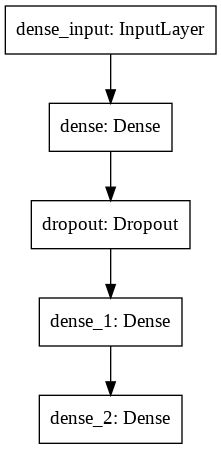

In [ ]:
model = create_nn_model()
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2944      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.1,       # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=50,        # The number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,         # 0: quiet - 1: update messages.
    mode="auto",       # {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; 
                       # in the max mode it will be reduced when the quantity monitored has stopped increasing; 
                       # in auto mode, the direction is automatically inferred from the name of the monitored quantity.
    min_delta=0.0001,  # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,        # number of epochs to wait before resuming normal operation after learning rate (lr) has been reduced.
    min_lr=0.00001     # lower bound on the learning rate.
    )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, restore_best_weights=True)


# callbacks=[learning_rate_reduction,es]

In [ ]:
history = model.fit(Xtrain,ytrain,validation_data=(Xtest,ytest),batch_size=16,epochs=200,verbose=2,callbacks=[learning_rate_reduction,es])

Epoch 1/200
44/44 - 2s - loss: 0.7230 - accuracy: 0.5014 - precision: 0.7679 - recall: 0.1141 - val_loss: 0.7208 - val_accuracy: 0.5086 - val_precision: 0.9091 - val_recall: 0.1053
Epoch 2/200
44/44 - 0s - loss: 0.7180 - accuracy: 0.5144 - precision: 0.7600 - recall: 0.1512 - val_loss: 0.7144 - val_accuracy: 0.5486 - val_precision: 0.8333 - val_recall: 0.2105
Epoch 3/200
44/44 - 0s - loss: 0.7128 - accuracy: 0.5460 - precision: 0.8081 - recall: 0.2122 - val_loss: 0.7066 - val_accuracy: 0.6114 - val_precision: 0.8462 - val_recall: 0.3474
Epoch 4/200
44/44 - 0s - loss: 0.7033 - accuracy: 0.6307 - precision: 0.7752 - recall: 0.4483 - val_loss: 0.6976 - val_accuracy: 0.7429 - val_precision: 0.8378 - val_recall: 0.6526
Epoch 5/200
44/44 - 0s - loss: 0.6940 - accuracy: 0.7256 - precision: 0.8298 - recall: 0.6207 - val_loss: 0.6877 - val_accuracy: 0.7829 - val_precision: 0.8202 - val_recall: 0.7684
Epoch 6/200
44/44 - 0s - loss: 0.6841 - accuracy: 0.7859 - precision: 0.8333 - recall: 0.7560 -

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


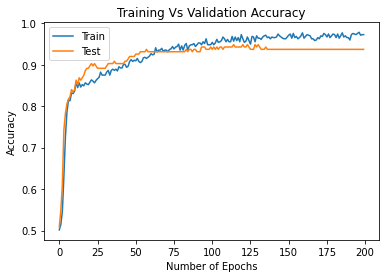

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Training_validation_accuracy_2L_1D_128_64_FLAT.png')
plt.show()

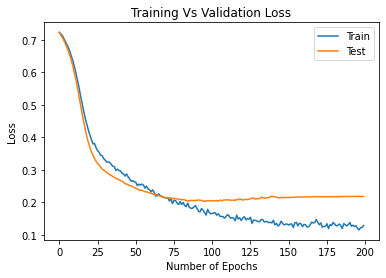

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Test'])
plt.savefig('Training_Validation_loss_2L_1D_128_64_FLAT.png')
plt.show()

### RESULTS & METRICS

In [ ]:
scores = model.evaluate(Xtrain, ytrain)
print(f'Accuracy: {scores[1]} \n Error: {1 - scores[1]}')

22/22 [==============================] - 0s 3ms/step - loss: 0.1146 - accuracy: 0.9713 - precision: 0.9811 - recall: 0.9655
Accuracy: 0.9712643623352051 
 Error: 0.028735637664794922


In [ ]:
# 2LAYERS , 1 DROPOUTS , 128 AND 64 NEURONS
scores = model.evaluate(Xtest, ytest)
print(f'Accuracy: {scores[1]} \n Error: {1 - scores[1]}')

6/6 [==============================] - 0s 2ms/step - loss: 0.2182 - accuracy: 0.9371 - precision: 0.9200 - recall: 0.9684
Accuracy: 0.9371428489685059 
 Error: 0.06285715103149414


### Final Model on Full Data

In [ ]:
scores = model.evaluate(X, y)
print(f'Accuracy: {scores[1]} \n Error: {1 - scores[1]}')

28/28 [==============================] - 0s 1ms/step - loss: 0.1161 - accuracy: 0.9736 - precision: 0.9849 - recall: 0.9661
Accuracy: 0.9735935926437378 
 Error: 0.026406407356262207


In [ ]:
# 2LAYERS , 2 DROPOUTS , 128 AND 64 NEURONS , ACCURACY = 94.86

scores = model.evaluate(Xtest, ytest)
print(f'Accuracy: {scores[1]} \n Error: {1 - scores[1]}')

6/6 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.9257 - precision: 0.9362 - recall: 0.9263
Accuracy: 0.9257143139839172 
 Error: 0.07428568601608276


In [ ]:
y_neural_pred = model.predict(Xtest)

y_label_predictions = tf.round(y_neural_pred).numpy().flatten()

confusionMatrix = confusion_matrix(ytest,y_label_predictions)
print('Confusion Matrix')
print(confusionMatrix)
print()
print(len(Xtest))
print()
print('Classification Report')
print()
classNames = ['No Disease', 'Disease']
print(classification_report(ytest,y_label_predictions, target_names=classNames))


Confusion Matrix
[[72  8]
 [ 3 92]]

175

Classification Report

              precision    recall  f1-score   support

  No Disease       0.96      0.90      0.93        80
     Disease       0.92      0.97      0.94        95

    accuracy                           0.94       175
   macro avg       0.94      0.93      0.94       175
weighted avg       0.94      0.94      0.94       175



## SAVING ORIGINAL MODEL 

In [ ]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model
model.save('saved_model/harp_orig_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('saved_model/harp_orig_model.h5')

In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [ ]:
Xtest[0].reshape(-1,22).shape

(1, 22)

In [ ]:
res = model.predict_proba(Xtest[3].reshape(-1,22))
res

array([[0.3967356]], dtype=float32)

In [ ]:
disProb =   round(res[0][0],1)*100
noDiseas =  100 - disProb
noDiseas

59.99999940395355

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2944      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


### TENSORFLOW LITE MODEL

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(path + 'proceedit_har_adam_tflite_model_2L_2D__16_9799_9429.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzxjoia18/assets


INFO:tensorflow:Assets written to: /tmp/tmpzxjoia18/assets


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model.
with tf.io.gfile.GFile(path + 'proceedit_har_adam_tflite_model_2L_1D20_9856_92_gfile.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpijaqr396/assets


INFO:tensorflow:Assets written to: /tmp/tmpijaqr396/assets


In [ ]:
import joblib
deepL_har_model = path + 'proceedit_har_adam_tflite_model_2L_2D__16_9799_9429.tflite'
joblib.dump(tflite_model,deepL_har_model)

# deepL_har_model_output = joblib.load(deepL_har_model)

['/content/drive/My Drive/Colab Notebooks/Proceedit/proceedit_har_adam_tflite_model_2L_2D__16_9799_9429.tflite']